# U-Net Model for RV Segmentation

## Training U-Net CNN

In [1]:
import sys
sys.path.append("..")
import os, re, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src import data,unet

Using TensorFlow backend.


In [2]:
from keras import utils

train_dir = "/home/ubuntu/training/TrainingSet"
#train_dir = "/Users/aksharkumar/Documents/mlndCapstone/trainingdata/TrainingSet"

images=[]
inner_masks=[]
outer_masks = []

patient_directories = sorted(glob.glob(os.path.join(train_dir, "patient*")))

for patient_dir in patient_directories:
    imgdata = data.ImageData(patient_dir)
    images += imgdata.labeled_images
    inner_masks += imgdata.endo_masks.values()
    outer_masks += imgdata.epi_masks.values()

images = np.asarray(images)[:,:,:,None].astype('float64')
i_masks = np.asarray(inner_masks)
o_masks = np.asarray(outer_masks)

dims = i_masks.shape
classes = len(set(i_masks[0].flatten()))
new_shape = dims + (classes,)
i_masks = utils.to_categorical(i_masks).reshape(new_shape)
o_masks = utils.to_categorical(o_masks).reshape(new_shape)

print("There are %d total training images." % len(images))
print("There are %d total inner masks." % len(inner_masks))
print("There are %d total outer masks." % len(outer_masks))


There are 243 total training images.
There are 243 total inner masks.
There are 243 total outer masks.


In [3]:
height,width,_ = images[0].shape
dropout = 0

unet_conv = unet.UNet()

model = unet_conv.get_unet(height=height,width=width,channels=1,features=32,steps=3,dropout=dropout,padding='same')

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 216, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 216, 256, 32)  320         input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 216, 256, 32)  0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 216, 256, 32)  0           activation_1[0][0]               
___________________________________________________________________________________________

In [4]:
from keras.optimizers import Adam
from keras import backend as K

def dice_coef(y_true, y_pred):
        flat_y_true = K.flatten(y_true)
        flat_y_preds = K.flatten(y_pred)
        intersection = K.sum(flat_y_true*flat_y_preds)
        return (2. * intersection + 1.) / (K.sum(flat_y_true)+K.sum(flat_y_preds))

def show_plots(history):    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=[dice_coef])

In [5]:
#TODO: 1. split data into training and validation set
#      2. Augment the data
#      3. Train model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from math import ceil

seed = 0

validation_split=0.2

epochs = 200
batch_size = 20


split_index = int((1 - validation_split) * len(images))

train_steps = ceil(split_index / batch_size)
val_steps = ceil((len(images)-split_index )/batch_size)

train_images = images[:split_index]
train_inner_masks = i_masks[:split_index]

validation_images = images[split_index:]
validation_inner_masks = i_masks[split_index:]


data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.01,
                     fill_mode='nearest')

train_images_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**data_gen_args)


seed = 1
#height,width,channels = train_images[0].shape
#print(train_images[0].shape)
#print(train_inner_masks[0].shape)
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_inner_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_inner_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)


/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [13]:
checkpointer = ModelCheckpoint(filepath='saved_models/endo_models/weightsNoDrop.hdf5', verbose=1, save_best_only=True)

hist = model.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=2,callbacks=[checkpointer],
                   validation_data=(validation_images,validation_inner_masks),validation_steps=val_steps)
#show_plots(hist)

Epoch 1/200
Epoch 00000: val_loss improved from inf to 0.68469, saving model to saved_models/endo_models/weightsNoDrop.hdf5
16s - loss: 0.6932 - dice_coef: 0.5002 - val_loss: 0.6847 - val_dice_coef: 0.5044
Epoch 2/200
Epoch 00001: val_loss improved from 0.68469 to 0.66212, saving model to saved_models/endo_models/weightsNoDrop.hdf5
15s - loss: 0.6742 - dice_coef: 0.5100 - val_loss: 0.6621 - val_dice_coef: 0.5164
Epoch 3/200
Epoch 00002: val_loss improved from 0.66212 to 0.60857, saving model to saved_models/endo_models/weightsNoDrop.hdf5
14s - loss: 0.6352 - dice_coef: 0.5318 - val_loss: 0.6086 - val_dice_coef: 0.5473
Epoch 4/200
Epoch 00003: val_loss improved from 0.60857 to 0.50468, saving model to saved_models/endo_models/weightsNoDrop.hdf5
15s - loss: 0.5578 - dice_coef: 0.5821 - val_loss: 0.5047 - val_dice_coef: 0.6186
Epoch 5/200
Epoch 00004: val_loss improved from 0.50468 to 0.38493, saving model to saved_models/endo_models/weightsNoDrop.hdf5
14s - loss: 0.4404 - dice_coef: 0.68

Epoch 00042: val_loss did not improve
15s - loss: 0.1860 - dice_coef: 0.8840 - val_loss: 0.1827 - val_dice_coef: 0.9152
Epoch 44/200
Epoch 00043: val_loss did not improve
15s - loss: 0.1805 - dice_coef: 0.9048 - val_loss: 0.1836 - val_dice_coef: 0.8928
Epoch 45/200
Epoch 00044: val_loss did not improve
14s - loss: 0.1975 - dice_coef: 0.8856 - val_loss: 0.1826 - val_dice_coef: 0.8928
Epoch 46/200
Epoch 00045: val_loss improved from 0.17960 to 0.17924, saving model to saved_models/endo_models/weightsNoDrop.hdf5
15s - loss: 0.1744 - dice_coef: 0.8988 - val_loss: 0.1792 - val_dice_coef: 0.9130
Epoch 47/200
Epoch 00046: val_loss did not improve
14s - loss: 0.1852 - dice_coef: 0.8885 - val_loss: 0.1811 - val_dice_coef: 0.8942
Epoch 48/200
Epoch 00047: val_loss improved from 0.17924 to 0.17808, saving model to saved_models/endo_models/weightsNoDrop.hdf5
15s - loss: 0.1783 - dice_coef: 0.9024 - val_loss: 0.1781 - val_dice_coef: 0.9135
Epoch 49/200
Epoch 00048: val_loss improved from 0.17808 to

Epoch 00093: val_loss did not improve
14s - loss: 0.1642 - dice_coef: 0.9024 - val_loss: 0.1536 - val_dice_coef: 0.9093
Epoch 95/200
Epoch 00094: val_loss improved from 0.15285 to 0.15164, saving model to saved_models/endo_models/weightsNoDrop.hdf5
15s - loss: 0.1548 - dice_coef: 0.9112 - val_loss: 0.1516 - val_dice_coef: 0.9135
Epoch 96/200
Epoch 00095: val_loss improved from 0.15164 to 0.15153, saving model to saved_models/endo_models/weightsNoDrop.hdf5
14s - loss: 0.1475 - dice_coef: 0.9140 - val_loss: 0.1515 - val_dice_coef: 0.9138
Epoch 97/200
Epoch 00096: val_loss improved from 0.15153 to 0.15118, saving model to saved_models/endo_models/weightsNoDrop.hdf5
15s - loss: 0.1499 - dice_coef: 0.9162 - val_loss: 0.1512 - val_dice_coef: 0.9158
Epoch 98/200
Epoch 00097: val_loss did not improve
14s - loss: 0.1463 - dice_coef: 0.9135 - val_loss: 0.1517 - val_dice_coef: 0.9157
Epoch 99/200
Epoch 00098: val_loss did not improve
15s - loss: 0.1630 - dice_coef: 0.9119 - val_loss: 0.1519 - val

Epoch 00146: val_loss did not improve
14s - loss: 0.1572 - dice_coef: 0.9136 - val_loss: 0.1458 - val_dice_coef: 0.9148
Epoch 148/200
Epoch 00147: val_loss improved from 0.14491 to 0.14375, saving model to saved_models/endo_models/weightsNoDrop.hdf5
15s - loss: 0.1475 - dice_coef: 0.9135 - val_loss: 0.1437 - val_dice_coef: 0.9177
Epoch 149/200
Epoch 00148: val_loss did not improve
15s - loss: 0.1424 - dice_coef: 0.9136 - val_loss: 0.1458 - val_dice_coef: 0.9252
Epoch 150/200
Epoch 00149: val_loss did not improve
14s - loss: 0.1360 - dice_coef: 0.9217 - val_loss: 0.1478 - val_dice_coef: 0.9099
Epoch 151/200
Epoch 00150: val_loss did not improve
15s - loss: 0.1444 - dice_coef: 0.9175 - val_loss: 0.1448 - val_dice_coef: 0.9204
Epoch 152/200
Epoch 00151: val_loss did not improve
14s - loss: 0.1403 - dice_coef: 0.9158 - val_loss: 0.1454 - val_dice_coef: 0.9231
Epoch 153/200
Epoch 00152: val_loss did not improve
15s - loss: 0.1447 - dice_coef: 0.9174 - val_loss: 0.1462 - val_dice_coef: 0.910

AttributeError: module 'matplotlib' has no attribute 'plot'

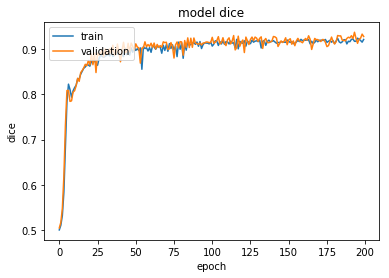

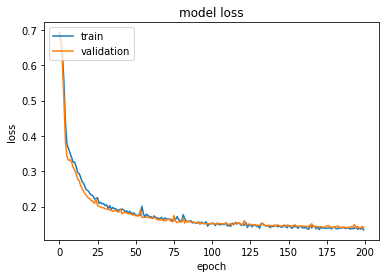

In [15]:
#print(np.max(hist.history['val_dice_coef']))
#print(np.max(hist.history['dice_coef']))

# model.load_weights('saved_models/weights.hdf5')
show_plots(hist)


In [7]:
model.load_weights('saved_models/endo_models/weightsNoDrop.hdf5')
def calculate_dice(images, masks_true):
    dices = []
    metrics = model.evaluate(images,masks_true,batch_size=batch_size)
    #for mask_true, mask_pred in zip(masks_true, masks_pred):
     #   y_true = mask_true[:,:,1]
      #  y_pred = mask_pred[:,:,1]
       # dices.append(dice_coef(y_true, y_pred))
    #print(metrics)
    print("Dice: {:.2f} Loss: {:.2f}".format(metrics[1], metrics[0]))
    
print("Training Statistics(No Dropout)...")
calculate_dice(train_images,train_inner_masks)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images,validation_inner_masks)


Training Statistics(No Dropout)...
194/194 [==============================] - 3s     
Dice: 0.92 Loss: 0.14
Validation Statistics(No Dropout)...
49/49 [==============================] - 0s     
Dice: 0.93 Loss: 0.12


# Results of Endocardium Model

## Training
hyperparams: {Dropout:0.5, Epochs:50, Batch Size: 20}

- train_dice = 0.62365097794
- val_dice = 0.522672422078

hyperparams: {Dropout:0.5, Epochs: 200, Batch Size: 20}

- train_dice = 0.878794970879
- val_dice = 0.841971736781


In [8]:
model_epi = unet_conv.get_unet(height=height,width=width,channels=1,features=32,steps=3,dropout=dropout,padding='same')

model_epi.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 216, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_16 (Conv2D)               (None, 216, 256, 32)  320         input_2[0][0]                    
____________________________________________________________________________________________________
activation_15 (Activation)       (None, 216, 256, 32)  0           conv2d_16[0][0]                  
____________________________________________________________________________________________________
dropout_15 (Dropout)             (None, 216, 256, 32)  0           activation_15[0][0]              
___________________________________________________________________________________________

In [9]:
seed_epi = 10

train_outer_masks = o_masks[:split_index]

train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_outer_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_outer_masks, y=None, seed=seed)


train_outer_generator = zip(train_images_generator, train_masks_generator)

validation_outer_masks = o_masks[split_index:]


/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [10]:
model_epi.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=[dice_coef])
checkpointer = ModelCheckpoint(filepath='saved_models/epi_models/weightsNoDrop.hdf5',verbose=1,save_best_only=True)

hist_epi = model_epi.fit_generator(train_outer_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=2,callbacks=[checkpointer],
                                 validation_data=(validation_images,validation_outer_masks),validation_steps=val_steps)

Epoch 1/200
Epoch 00000: val_loss improved from inf to 0.62896, saving model to saved_models/epi_models/weightsNoDrop.hdf5
24s - loss: 0.6504 - dice_coef: 0.5231 - val_loss: 0.6290 - val_dice_coef: 0.5353
Epoch 2/200
Epoch 00001: val_loss improved from 0.62896 to 0.55310, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.5887 - dice_coef: 0.5614 - val_loss: 0.5531 - val_dice_coef: 0.5850
Epoch 3/200
Epoch 00002: val_loss improved from 0.55310 to 0.45783, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.4972 - dice_coef: 0.6345 - val_loss: 0.4578 - val_dice_coef: 0.6693
Epoch 4/200
Epoch 00003: val_loss improved from 0.45783 to 0.40975, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.4287 - dice_coef: 0.7244 - val_loss: 0.4098 - val_dice_coef: 0.7504
Epoch 5/200
Epoch 00004: val_loss improved from 0.40975 to 0.39880, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.4228 - dice_coef: 0.7733 - 

Epoch 00042: val_loss did not improve
15s - loss: 0.2086 - dice_coef: 0.8729 - val_loss: 0.2034 - val_dice_coef: 0.8959
Epoch 44/200
Epoch 00043: val_loss did not improve
15s - loss: 0.2321 - dice_coef: 0.8526 - val_loss: 0.2116 - val_dice_coef: 0.8530
Epoch 45/200
Epoch 00044: val_loss improved from 0.20066 to 0.19930, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.2073 - dice_coef: 0.8810 - val_loss: 0.1993 - val_dice_coef: 0.8889
Epoch 46/200
Epoch 00045: val_loss did not improve
15s - loss: 0.2258 - dice_coef: 0.8612 - val_loss: 0.2060 - val_dice_coef: 0.8610
Epoch 47/200
Epoch 00046: val_loss improved from 0.19930 to 0.19774, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.2151 - dice_coef: 0.8732 - val_loss: 0.1977 - val_dice_coef: 0.8825
Epoch 48/200
Epoch 00047: val_loss improved from 0.19774 to 0.19715, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.2141 - dice_coef: 0.8692 - val_loss: 0.1972 - val_di

Epoch 00094: val_loss did not improve
15s - loss: 0.1970 - dice_coef: 0.8790 - val_loss: 0.1780 - val_dice_coef: 0.9006
Epoch 96/200
Epoch 00095: val_loss did not improve
14s - loss: 0.2024 - dice_coef: 0.8770 - val_loss: 0.1808 - val_dice_coef: 0.8795
Epoch 97/200
Epoch 00096: val_loss did not improve
15s - loss: 0.2013 - dice_coef: 0.8768 - val_loss: 0.1767 - val_dice_coef: 0.8898
Epoch 98/200
Epoch 00097: val_loss did not improve
14s - loss: 0.1757 - dice_coef: 0.8939 - val_loss: 0.1774 - val_dice_coef: 0.8866
Epoch 99/200
Epoch 00098: val_loss did not improve
15s - loss: 0.2064 - dice_coef: 0.8767 - val_loss: 0.1943 - val_dice_coef: 0.8596
Epoch 100/200
Epoch 00099: val_loss did not improve
15s - loss: 0.1884 - dice_coef: 0.8825 - val_loss: 0.1765 - val_dice_coef: 0.8917
Epoch 101/200
Epoch 00100: val_loss did not improve
14s - loss: 0.1964 - dice_coef: 0.8768 - val_loss: 0.1785 - val_dice_coef: 0.9035
Epoch 102/200
Epoch 00101: val_loss did not improve
15s - loss: 0.1770 - dice_co

Epoch 00150: val_loss improved from 0.16689 to 0.16675, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.1766 - dice_coef: 0.8910 - val_loss: 0.1668 - val_dice_coef: 0.8956
Epoch 152/200
Epoch 00151: val_loss did not improve
14s - loss: 0.1636 - dice_coef: 0.9000 - val_loss: 0.1692 - val_dice_coef: 0.8997
Epoch 153/200
Epoch 00152: val_loss did not improve
15s - loss: 0.1707 - dice_coef: 0.9000 - val_loss: 0.1693 - val_dice_coef: 0.9020
Epoch 154/200
Epoch 00153: val_loss improved from 0.16675 to 0.16596, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.1817 - dice_coef: 0.8893 - val_loss: 0.1660 - val_dice_coef: 0.8973
Epoch 155/200
Epoch 00154: val_loss did not improve
15s - loss: 0.1747 - dice_coef: 0.8904 - val_loss: 0.1674 - val_dice_coef: 0.9060
Epoch 156/200
Epoch 00155: val_loss did not improve
15s - loss: 0.1794 - dice_coef: 0.8924 - val_loss: 0.1696 - val_dice_coef: 0.9050
Epoch 157/200
Epoch 00156: val_loss did not improve
14s 

In [ ]:
show_plots(hist_epi)